# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


Populating the interactive namespace from numpy and matplotlib


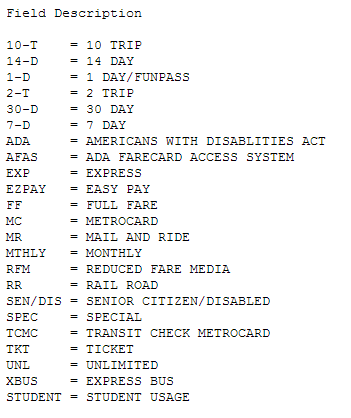

In [3]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

In [4]:
class ArrayDataLoader():
    # intialization construtor 
    def __init__(self, data):
        try:
            self.data = data
            self.buffer = data
        except ValueError:
            print("Initialization Failed.")
    # return self.data 
    def get_data(self):
        try:
            self.buffer = self.buffer.astype('float')
            self.buffer[self.buffer==-1] = 0
            return self.buffer
        except ValueError:
            print("Unable to get data.")
    # same as before but return Nan 
    def get_data_nan(self):
        try:
            self.buffer = self.buffer.astype('float')
            self.buffer[self.buffer==-1] = np.nan
            return self.buffer
        except ValueError:
            print("Unable to get data.")
    # print data summary 
    def summary(self):
        try:
            print("MTA array shape:", self.data.shape)
            print("MTA array shape summed over all ride types:", np.nansum(self.data,axis=1).shape)
        except ValueError:
            print("Cannot get the summary report of the data")
    # plot all data 
    def plot_all_data(self, dataset):
        # figure size
        plt.figure(figsize=(20,6))
        # loop 2d array and plot graph
        for i in range(0, len(dataset)):
            for j in range(0, len(dataset[i])):
                try:
                    mtaRidesPerWeek = pd.DataFrame(dataset[i][j])
                    plt.plot(range(0, 194), np.log10(mtaRidesPerWeek))
                except ValueError:
                    print("Unable to plot the graph")
        # set the title           
        plt.title('time series for all ride types and all stations in semi-log space', fontsize=20)
        plt.xlabel('weeks since 05/21/2010', fontsize=20)
        plt.ylabel('swipes (log10)', fontsize=20)
    # plot the natural data without log 
    def plot_all_data_natural(self, dataset):
        # figure size
        plt.figure(figsize=(20,6))
        # loop 2d array and plot graph
        for i in range(0, len(dataset)):
            for j in range(0, len(dataset[i])):
                try:
                    mtaRidesPerWeek = pd.DataFrame(dataset[i][j])
                    plt.plot(range(0, 194), mtaRidesPerWeek)
                except ValueError:
                    print("Unable to plot the graph")
        # set the title           
        plt.title('time series for all ride types and all stations', fontsize=20)
        plt.xlabel('weeks since 05/21/2010', fontsize=20)
        plt.ylabel('swipes', fontsize=20)
    # print and return outlier threshood and date 
    def get_outlier(self):
        # dummy dataset 10 10
        mtaRidesPerWeek = pd.DataFrame(np.nansum(np.nansum(mta_rides,axis=0),axis=0),
                               columns=['ride'])
        # mean std of the sample dataset 
        mean, std = mtaRidesPerWeek.ride.mean(), mtaRidesPerWeek.ride.std()
        # index of our target outlier week 
        thresholds = [mean - 3 * std, mean + 3 * std]
        index = mtaRidesPerWeek[(mtaRidesPerWeek.ride < thresholds[1]) |
                (mtaRidesPerWeek.ride > thresholds[0])].index[0]
        # return lower, upper, weekdays of the outlier week 
        return mean - 3 * std, mean + 3 * std, \
    pd.date_range('05/21/2010','02/21/2014',freq='W-FRI')[:-1][index: index + 5]
    # iterate through data and return sum of ith feature at jth week 
    def get_feature(self, type_num, week_num, mta_rides):
        swipe_per_station_per_type = []
        for i in range(0, len(mta_rides)):
            swipe_per_station_per_type.append(mta_rides[i][type_num][week_num])
        return swipe_per_station_per_type
    # non smoothed 
    def get_series_stats_non_smooth(self, i):
        print('-' * 20 )
        print('Series number %d' % (i))
        print('std: %f' % (np.array(rides[i]).std()))
        print('fractional change over time: %f' % (rides[i][193] / rides[i][0]))
        return rides[i][193] / rides[i][0]
    # smoothed 
    def get_series_stats_smooth(self, i):
        rm = mta_rides_df.loc[i].rolling(1).mean()
        print('-' * 20 )
        print('Series number %d' % (i))
        print('std: %f' % (rm.std()))
        print('fractional change over time: %f' % (rm[193] / rm[0]))
        return rm[193] / rm[0]

# read in data as instructed above

In [5]:
mta = ArrayDataLoader(np.load("MTA_Fare.npy"))
mta.summary()

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [6]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


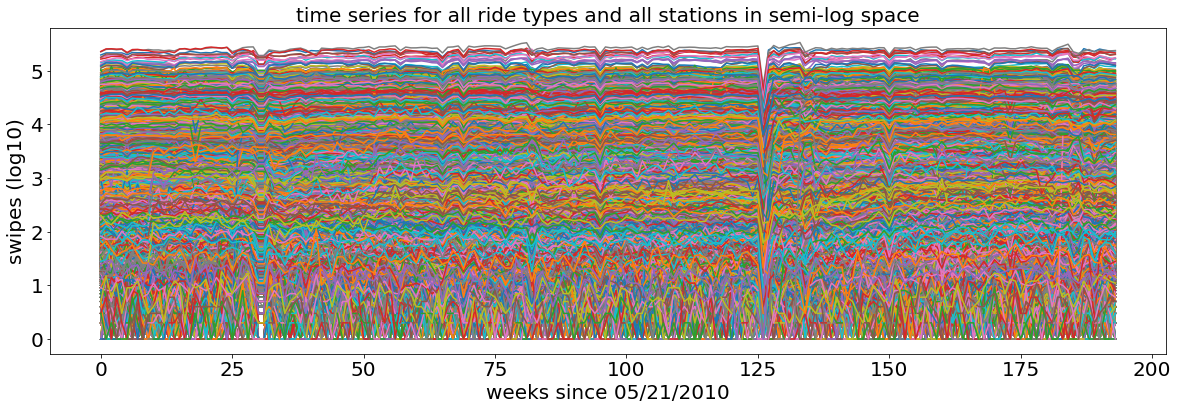

In [8]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
mta_rides = mta.get_data()
mta.plot_all_data(mta_rides)

#### Figure 1: time series for all ride types and all stations in semi-log space

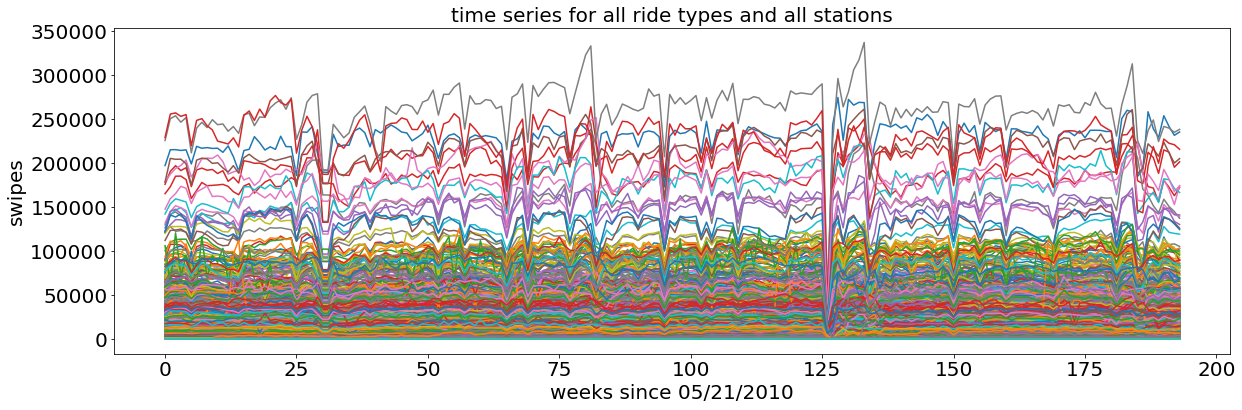

In [9]:
mta.plot_all_data_natural(mta_rides)

#### Figure 2: time series for all ride types and all stations without log 

# Task 4:
**Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)**

In [79]:
class ArrayDataCalculator(ArrayDataLoader):
    
    def __init__(self, df):
        super().__init__(df)
    # find best index with most power
    def find_index(self, df):
        INDEX = 4
        station_power = {}
        for col in rides_week_station.columns:
            power = np.abs(np.fft.rfft(rides_week_station[col]))
            station_power[col] = power[INDEX]
        return sorted(station_power.items(), key=lambda x : x[1], reverse=True)[:4]
    # print result 
    def summarize(self, li):
        for i in range(0, len(station_lists)):
            print('Station ' + str(station_lists[i][0]) + ' has power of ' + str(station_lists[i][1]))
    # plot the desired dataframe 
    def plot(self, df, index):
        # plot them respectively
        plt.figure(figsize=(10,6))
        plt.plot(df[index][:52])
        plt.xlabel('Week', fontsize=16)
        plt.ylabel('RideShip', fontsize=16)
        plt.title('Week vs. Ridership', fontsize=16)
        plt.grid(b=True)

In [80]:
# create data frame 
rides_week = pd.DataFrame(np.nansum(np.nansum(mta_rides,axis=0),axis=0),
                               columns=['rides_of_week'])
rides_week_station = pd.DataFrame(np.nansum(mta_rides,axis=1).T,index = rides_week.index)

In [81]:
rides_week_station.head(3)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
rides_week_station.shape

(194, 600)

In [83]:
station_lists = ArrayDataCalculator(rides_week_station).find_index(rides_week_station)

In [84]:
# output the first 4 stations with their respective power 
ArrayDataCalculator(rides_week_station).summarize(station_lists)

Station 0 has power of 2980160.635595354
Station 194 has power of 2950388.929214199
Station 150 has power of 2931895.876951343
Station 327 has power of 2402218.5809588605


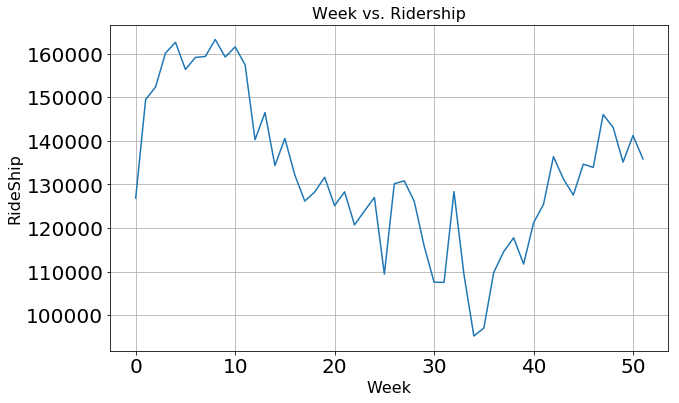

In [85]:
ArrayDataCalculator(rides_week_station).plot(rides_week_station, 0)

### Figure 1: Week vs. Ridership in week 0

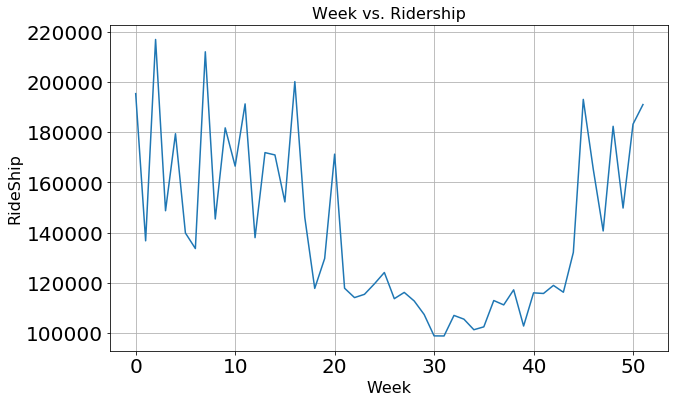

In [89]:
ArrayDataCalculator(rides_week_station).plot(rides_week_station, 194)

### Figure 1: Week vs. Ridership in week 194

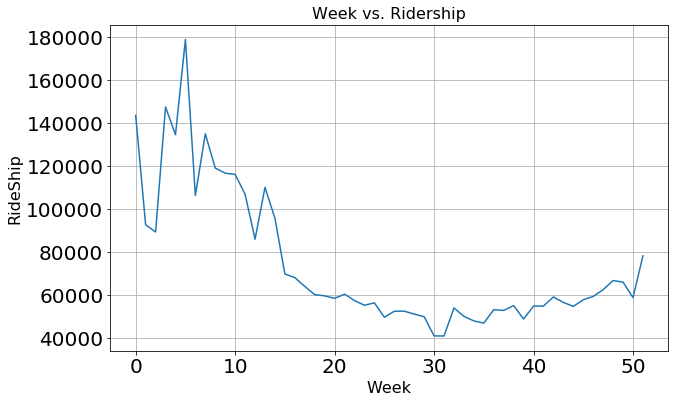

In [87]:
ArrayDataCalculator(rides_week_station).plot(rides_week_station, 150)

### Figure 1: Week vs. Ridership in week 150

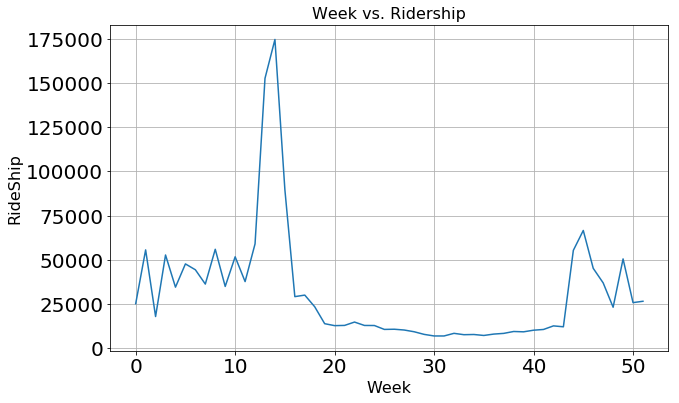

In [88]:
ArrayDataCalculator(rides_week_station).plot(rides_week_station, 327)

### Figure 1: Week vs. Ridership in week 327